In [1]:
from src import utils, InfoQGAN
from src.InfoQGAN import Discriminator, Generator, T

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import ndtest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import wandb
LOG_WANDB = False # set to true to log runs with weights and biases

## Central Square Distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


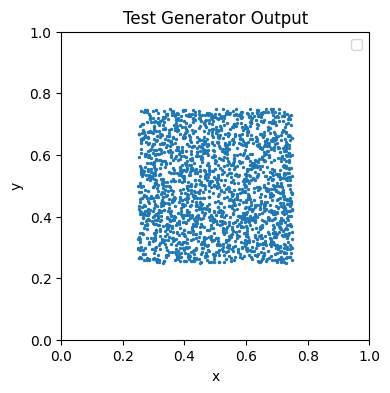

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# Get PyTorch Dataset and Dataloader
N = 2000
batch_size = 80

x, y = utils.generate_central_square(N)
dataset = utils.XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)
utils.plot_xy(x, y)

In [3]:
# Define Models and Model Hyperparameters
noise_size = 3
code_size = 2
beta = 0.1

D_model = Discriminator(2, 86)
G_model = Generator()
T_model = T(2, code_size, 80)

In [4]:
# Optimizers and LR definitions according to paper
criterion = nn.BCELoss()

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(D_model.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, gamma=gamma_d, step_size=30)
optimizer_G = optim.Adam(G_model.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, gamma=gamma_g, step_size=30)
optimizer_T = optim.Adam(T_model.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.StepLR(optimizer_T, gamma=gamma_t, step_size=30)

#### Core Training Loop

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

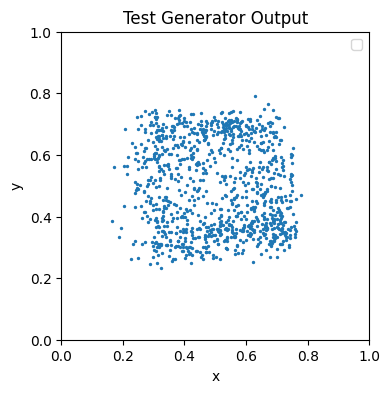

<Figure size 640x480 with 0 Axes>

In [5]:
d_error = []
g_error = []
t_error = []
fk_prog = []
best_p_value = -99
epochs = 300

# Fixed Noise for Visualization
fixed_noise = 2*torch.rand(1000, noise_size + code_size)-1

if LOG_WANDB:
    wandb.init(
        project='InfoQGAN',
        config = {
            "Generator Architecture": str(dict(G_model.named_modules())),
            "Discriminator Architecture": str(dict(D_model.named_modules())),
            "T Architecture": str(dict(T_model.named_modules())),
            "Batch Size": batch_size
        }
    )

for _ in range(epochs):
    for batch in dataloader:
        d_loss = D_model.fit_discriminator(batch, criterion, G_model, optimizer_D, noise_size+code_size)
        g_loss = G_model.fit_generator(D_model, T_model, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = T_model.fit_t(G_model, batch_size, noise_size+code_size, code_size, optimizer_T)

        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        if LOG_WANDB:
            wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
    
    scheduler_D.step()
    scheduler_G.step()
    scheduler_T.step()
    with torch.no_grad():
        fake = G_model(fixed_noise)
        acc = utils.boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        if LOG_WANDB: 
            wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        if LOG_WANDB: 
            wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2})

    if _ % 25 == 0:
        with torch.no_grad():
            fake = G_model(fixed_noise)
            clear_output(wait=True)
            fig = utils.plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
if LOG_WANDB:
    wandb.finish()

#### Evaluate Performance

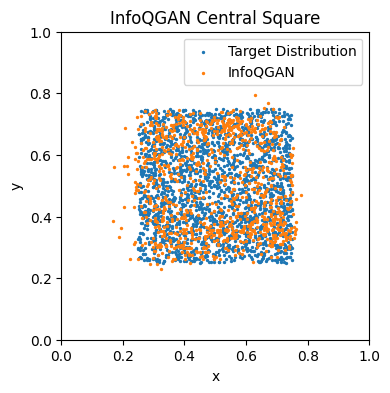

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
gen_output = G_model(fixed_noise)
x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()

utils.plot_xy_overlaid(x_test, y_test, x, y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


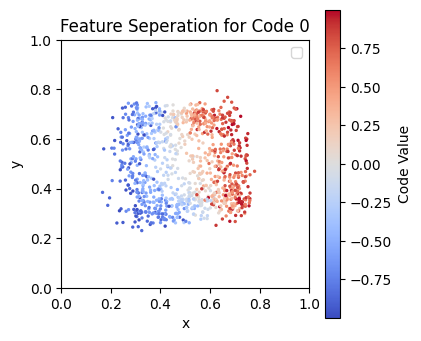

In [7]:
utils.plot_xy_codes(x_test, y_test, 0, fixed_noise)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


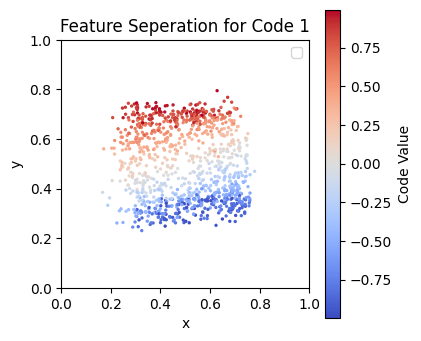

In [8]:
utils.plot_xy_codes(x_test, y_test, 1, fixed_noise)

## Biased Circle Distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


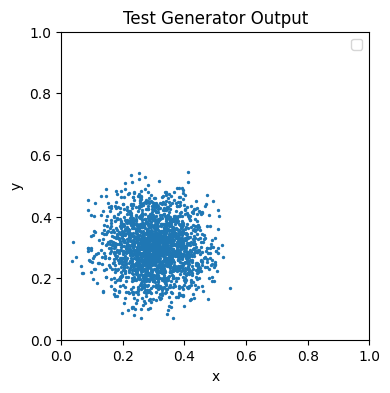

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
# Get PyTorch Dataset and Dataloader
N = 2000
batch_size = 80

x, y = utils.generate_biased_circle(N)
dataset = utils.XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)
utils.plot_xy(x, y)

In [10]:
# Define Models and Model Hyperparameters
noise_size = 3
code_size = 2
beta = 0.5

D_model = Discriminator(2, 86)
G_model = Generator()
T_model = T(2, code_size, 20)

In [11]:
# Optimizers and LR definitions according to paper
criterion = nn.BCELoss()

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(D_model.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, gamma=gamma_d, step_size=30)
optimizer_G = optim.Adam(G_model.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, gamma=gamma_g, step_size=30)
optimizer_T = optim.Adam(T_model.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.StepLR(optimizer_T, gamma=gamma_t, step_size=30)

#### Core Training Loop

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

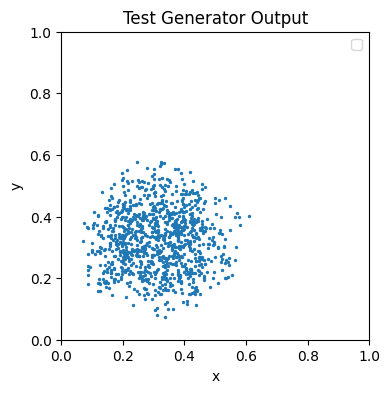

<Figure size 640x480 with 0 Axes>

In [12]:
d_error = []
g_error = []
t_error = []
fk_prog = []
best_p_value = -99
epochs = 300

# Fixed Noise for Visualization
fixed_noise = 2*torch.rand(1000, noise_size + code_size)-1

if LOG_WANDB:
    wandb.init(
        project='InfoQGAN',
        config = {
            "Generator Architecture": str(dict(G_model.named_modules())),
            "Discriminator Architecture": str(dict(D_model.named_modules())),
            "T Architecture": str(dict(T_model.named_modules())),
            "Batch Size": batch_size
        }
    )

for _ in range(epochs):
    for batch in dataloader:
        d_loss = D_model.fit_discriminator(batch, criterion, G_model, optimizer_D, noise_size+code_size)
        g_loss = G_model.fit_generator(D_model, T_model, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = T_model.fit_t(G_model, batch_size, noise_size+code_size, code_size, optimizer_T)

        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        if LOG_WANDB:
            wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
    
    scheduler_D.step()
    scheduler_G.step()
    scheduler_T.step()
    with torch.no_grad():
        fake = G_model(fixed_noise)
        acc = utils.boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        if LOG_WANDB: 
            wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = np.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = np.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        if LOG_WANDB: 
            wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2})

    if _ % 25 == 0:
        with torch.no_grad():
            fake = G_model(fixed_noise)
            clear_output(wait=True)
            fig = utils.plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
if LOG_WANDB:
    wandb.finish()

#### Evaluate Performance

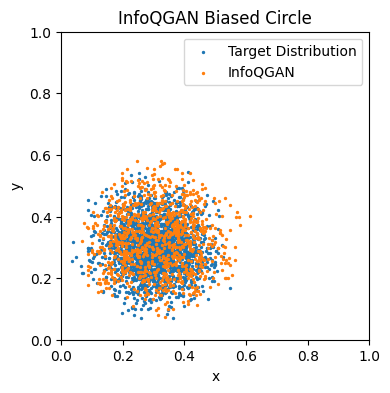

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
gen_output = G_model(fixed_noise)
x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()

utils.plot_xy_overlaid(x_test, y_test, x, y, label="Biased Circle")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


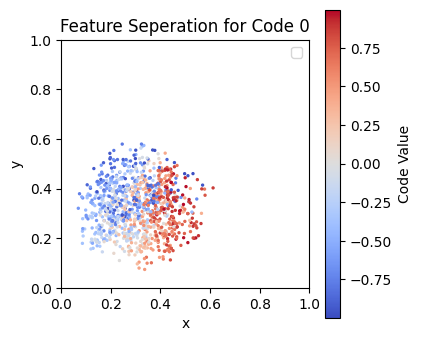

In [14]:
utils.plot_xy_codes(x_test, y_test, 0, fixed_noise)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


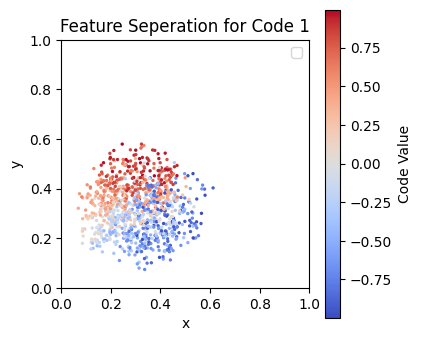

In [15]:
utils.plot_xy_codes(x_test, y_test, 1, fixed_noise)

Note: To achieve better code seperation than above learning rates need to be modified slightly from those given in paper. This difference could be due to model definitions not provided.

## Financial Return Distribution 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


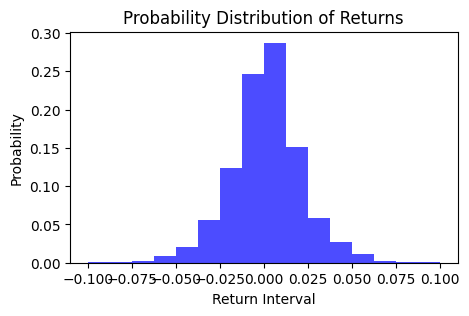

In [2]:
# Get PyTorch Dataset and Dataloader
N = 2000
batch_size = 80

dsets = utils.generate_stock_dataset()
dataset = utils.DistributionDataset(dsets)
dataloader = DataLoader(dataset, batch_size=batch_size)
utils.graph_distribution_financial(dsets[0])

In [9]:
# Define Models and Model Hyperparameters
noise_size = 3
code_size = 1
beta = 0.15

D_model = Discriminator(4**2, 24, use_financial=True)
G_model = Generator(use_financial=True)
T_model = T(4**2, code_size, 20, use_financial=True)

In [10]:
# Optimizers and LR definitions according to paper
criterion = nn.BCELoss()

lrd = 0.0004
lrg = 0.0004
lrt = 0.001
gamma_d = 0.7
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(D_model.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, gamma=gamma_d, step_size=30)
optimizer_G = optim.Adam(G_model.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, gamma=gamma_g, step_size=30)
optimizer_T = optim.Adam(T_model.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.StepLR(optimizer_T, gamma=gamma_t, step_size=30)

In [11]:
fixed_noise = torch.rand((512, noise_size + code_size)) 
f0 = fixed_noise.clone()
f5 = fixed_noise.clone()
f1 = fixed_noise.clone()
f0[:, 0] = 0.0
f5[:, 0] = 0.5
f1[:, 0] = 1.0

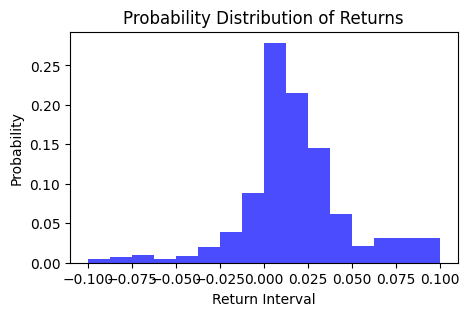

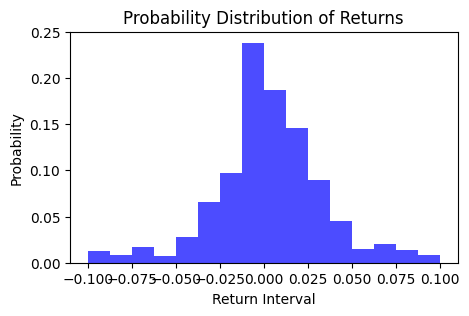

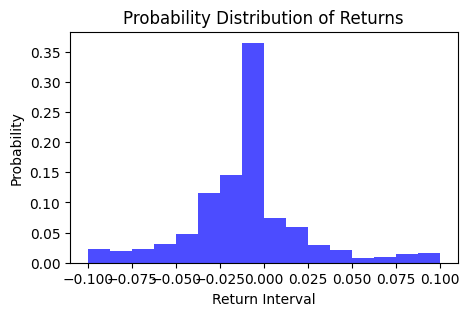

In [12]:
d_error = []
g_error = []
t_error = []
fk_prog = []
epochs = 450

if LOG_WANDB: 
    wandb.init(
        project='InfoQGAN',
        config = {
            "Generator Architecture": str(dict(G_model.named_modules())),
            "Discriminator Architecture": str(dict(D_model.named_modules())),
            "T Architecture": str(dict(T_model.named_modules())),
            "Batch Size": batch_size
        }
    )

for _ in range(epochs):
    for batch in dataloader:
        d_loss = D_model.fit_discriminator(batch, criterion, G_model, optimizer_D, noise_size+code_size)
        g_loss = G_model.fit_generator(D_model, T_model, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = T_model.fit_t(G_model, batch_size, noise_size+code_size, code_size, optimizer_T)

        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        if LOG_WANDB:
            wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
    
    scheduler_D.step()
    scheduler_G.step()
    scheduler_T.step()

    if _ % 20 == 0:
        with torch.no_grad():
            fake0 = G_model(f0)
            fake5 = G_model(f5)
            fake1 = G_model(f1)
            clear_output(wait=True)
            utils.graph_distribution_financial(torch.mean(fake0, dim=0).detach().numpy())
            utils.graph_distribution_financial(torch.mean(fake5, dim=0).detach().numpy())
            utils.graph_distribution_financial(torch.mean(fake1, dim=0).detach().numpy())
            
if LOG_WANDB:
    wandb.finish()

#### Evaluate Performance

In [13]:
def get_mean_sample(num_sampls, code):
    with torch.no_grad():
        noise = torch.rand(512, 4)
        noise[:,0] = code
        samples = G_model(noise)

    sample = torch.mean(samples, dim=0)
    return sample

def calculate_sample_mean(sample):
    sum = 0
    for i in range(len(sample)):
        return_value = (-0.1 + (0.2) * i / (len(sample))) + 0.2/32
        sum += return_value*sample[i]
    return sum

codes = np.linspace(0, 1, 16)
number_of_samples = 512
x = []
y = []

for code in codes:
    sample = get_mean_sample(number_of_samples, code)
    x.append(np.std(sample.numpy()))
    y.append(calculate_sample_mean(sample))

Text(0, 0.5, 'Mean')

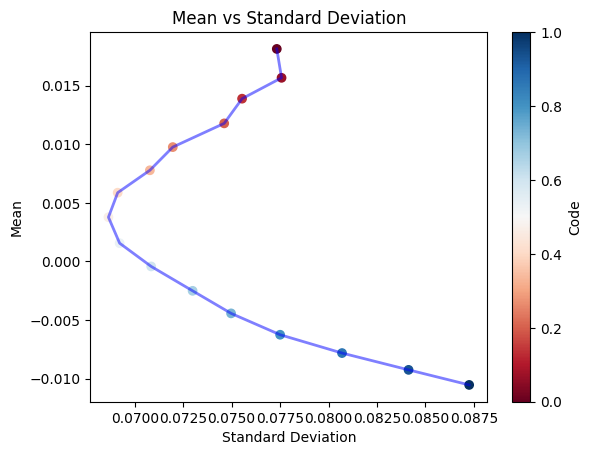

In [14]:
data = {
    'Standard Deviation': x,
    'Mean': y,
    'Code': codes
}
df = pd.DataFrame(data)

plt.scatter(df['Standard Deviation'], df['Mean'], c=df['Code'], cmap='RdBu')
plt.plot(df['Standard Deviation'], df['Mean'], c='blue', linewidth=2, alpha=0.5)
plt.colorbar(label='Code')
plt.title('Mean vs Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')

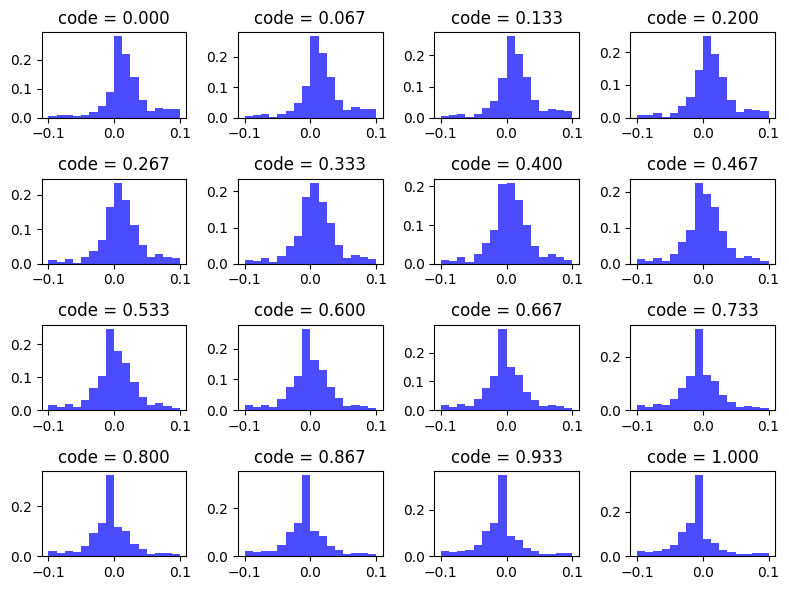

In [15]:
def generate_plot(ax, code):
    distribution = get_mean_sample(512, code)
    bin_edges = np.linspace(-0.1, 0.1, 17)  
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

    ax.bar(bin_centers, distribution, width=bin_edges[1] - bin_edges[0], align='center', color='blue', alpha=0.7)
    pass

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 6))
codes = np.linspace(0,1,16)  

for ax, code in zip(axes.flatten(), codes):
    generate_plot(ax, code)
    ax.set_title(f'code = {code:.3f}') 

plt.tight_layout()
plt.show()